In [1]:
import numpy as np
from numpy.matlib import repmat
import matplotlib.pyplot as plt
from tools import *
import seaborn
# from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
# init_notebook_mode(connected=True)
# import plotly.offline as py
# import plotly.graph_objs as go
# import seaborn as sns
# sns.set(color_codes=True)
# from IPython.html.widgets  import widgets
# import colorlover as cl

In [2]:
def hinge(w, data, y):
    data,y,w=data.reshape(len(y),-1),y.reshape(-1,1),w.reshape(1,-1)
    res = -y*(np.dot(data, w.T))
    res[res < 0] = 0
    return res.mean()

def grad_hinge(w, data, y):
    data,y,w=data.reshape(len(y),-1),y.reshape(-1,1),w.reshape(1,-1)
    l, col = np.shape(data)
    grad = -y*data
    res = -y*(np.dot(data, w.T))
    res = repmat(res, 1, col)
    grad = np.where(res<0, 0, grad)
    return grad.mean(axis=0)

In [41]:
class Perceptron:
    def __init__(self,max_iter = 100,eps=1e-3,projection = None):
        self.max_iter = max_iter
        self.eps = eps
        self.projection = projection or (lambda x: x) #projection fonction identite par default

    def fit(self,data,y):
        data = self.projection(data)
        self.w = np.random.random((1,data.shape[1]))
        self.winit = self.w.copy()
        self.histo_w  = np.zeros((self.max_iter,data.shape[1]))
        self.histo_f = np.zeros((self.max_iter,1))
        ylab=set(y.flat)
        if len(ylab) != 2:
            print("pas bon nombres de labels (%d)" % (ylab,))
            return
        self.labels = {-1: min(ylab), 1:max(ylab)}
        y = 2*(y!=self.labels[-1])-1
        i=0
        while i<self.max_iter:
            idx = range(len(data))
            for j in idx:
                self.w = self.w - self.get_eps()*self.loss_g(data[j],y[j:(j+1)])
            self.histo_w[i] = self.w
            self.histo_f[i] = self.loss(data,y)
            if i % 100==0: print(i,self.histo_f[i])
            i+=1
    def predict(self,data):
        data = self.projection(data)
        return np.array([self.labels[x] for x in np.sign(data.dot(self.w.T)).flat]).reshape((len(data),))
    def score(self,data,y):
        return np.mean(self.predict(data)==y)
    
    def predict_w(self, data, w):
        data = self.projection(data)
        return np.array([self.labels[x] for x in np.sign(data.dot(w.T)).flat]).reshape((len(data),))
    
    def score_w(self, data, y, w):
        return np.mean(self.predict_w(data, w)==y)

    def get_eps(self):
        return self.eps
    def loss(self,data,y):
        return hinge(self.w,data,y)
    def loss_g(self,data,y):
        return grad_hinge(self.w,data,y)
    
    def errors(self, data, y, legend=None):
        iterations = np.arange(self.max_iter)
        erreurs = []
        data = self.projection(data)
        for it in iterations:
            erreurs.append(1 - self.score_w(data, y,self.histo_w[it]))
        plt.plot(iterations, erreurs, label=legend)
        plt.xlabel("Nombre d'itérations")
        plt.ylabel("Erreur")

In [22]:
### Test des fonctions hinge, grad_hinge
w = np.random.random((3,))
data = np.random.random((100,3))
y = np.random.randint(0,2,size = (100,1))*2-1
print(hinge(w,data,y), hinge(w,data[0],y[0]), hinge(w,data[0,:],y[0]))
print(grad_hinge(w,data,y),grad_hinge(w,data[0],y[0]).shape,grad_hinge(w,data[0,:],y[0]).shape)

### Generation de donnees
xtrain,ytrain = gen_arti(data_type=0,epsilon=.2)
xtest,ytest = gen_arti(data_type=0,epsilon=.2)

plt.ion()

### Apprentissage
model= Perceptron(eps=1e-3)
model.fit(xtrain,ytrain)
print("score en train : ",model.score(xtrain,ytrain))
print("score en test : ",model.score(xtest,ytest))

0.386139538965 0.817057580061 0.817057580061
[ 0.28016992  0.27507592  0.22484225] (3,) (3,)
0 [ 0.00012047]
score en train :  0.999
score en test :  0.999


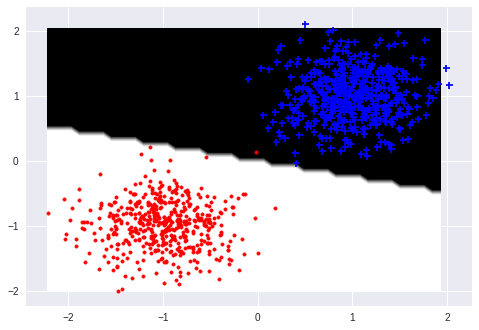

In [23]:
#### Tracer de frontiere
plt.figure()
plot_frontiere(xtrain,model.predict,50)
plot_data(xtrain,ytrain)

In [ ]:
# # Représentation de la trajectoire de w

# def slider_iter(max_iter, xinit, fonc, x_histo, f_histo,
#                 w=5, h=5, x1min=-3, x1max=3, x2min=-3, x2max=3,
#                 colorscale='Viridis'):

#     fig = plt.figure()

#     data = list()

#     x1 = np.linspace(x1min,x1max,num=30)
#     x2 = np.linspace(x2min,x2max,num=30)
#     y = np.array([[fonc([xi,yi]) for yi in x2] for xi in x1])
#     data_f = pd.DataFrame(data=y.T)

#     for ite in range(max_iter):

#         trace1 = go.Surface(
#             x = x1,
#             y = x2,
#             z = data_f.as_matrix(),
#             opacity=0.9,
#             colorscale=colorscale,
#             reversescale=False,
#             colorbar=dict(
#                 nticks=10,
#             ),
#             visible=ite<1,
#             name = "Hinge loss"
#         )

#         data.append(trace1)

#         xs = x_histo[:ite,0].reshape(-1)
#         ys = x_histo[:ite,1].reshape(-1)
#         zs = f_histo[:ite].reshape(-1)

#         trace2 = go.Scatter3d(
#             x=xs,
#             y=ys,
#             z=zs,
#             marker=dict(
#                 size=5,
#                 color='rgb(200, 0, 0)', # set color to an array/list of desired values   # choose a colorscale
#                 opacity=4,
#             ),
#             line=dict(
#                 color='rgb(200, 0, 0)',
#                 width=2
#             ),
#             visible=ite<1,
#             name="Itérations de la descente de gradient"
#         )

#         data.append(trace2)

#     steps = list()

#     for i in range(max_iter):

#         step = dict(
#             method='restyle',
#             args=['visible', [False] * max_iter * 2],
#             label='Itérations de la descente de Gradient {}'.format(i)
#         )
#         step['args'][1][i * 2] = True
#         step['args'][1][i * 2 + 1] = True
#         steps.append(step)

#     sliders = [dict(
#         active=0,
#         steps=steps
#     )]

#     layout = dict(sliders=sliders,
#                   margin=go.Margin(
#                         l=0,
#                         r=50,
#                         b=0,
#                         t=0,
#                     ),
#                  )

#     fig = dict(data=data, layout=layout)
#     py.iplot(fig, filename='Fonction de Rozenbrock')


In [ ]:
# def question35(eps=1e-3,
#                max_iter=20, centerx=1, sigma=0.1, nbex=1000,
#                data_type=0, epsilon=0.02, w2min=-3, w2max=3):

#     # Données artificielles:
#     xtrain, ytrain = gen_arti(centerx=centerx,
#                                   sigma=sigma,nbex=nbex,
#                                   data_type=data_type,epsilon=epsilon)
#     f = lambda w : hinge(w, xtrain, ytrain)
#     df = lambda w : grad_hinge(w, xtrain, ytrain)

#     # aquatic colorscale
#     cls=[[0, 'rgb(0,0,131)'], [0.0075, 'rgb(0,60,170)'],
#          [0.125, 'rgb(5,255,255)'], [0.325, 'rgb(255,255,0)'],
#          [0.575, 'rgb(250,0,0)'], [1, 'rgb(128,0,0)']]

#     model= Perceptron(eps=1e-3, max_iter=100)
#     model.fit(xtrain,ytrain)


#     slider_iter(max_iter, model.histo_w[0, :], model.histo_w, model.histo_f,
#                 colorscale=cls)

#     plot_data(xtrain, labels=ytrain)
#     plt.title('Représentation des données artificielles utilisées pour la classification',
#               fontsize=12)
#     plt.xlabel('X', fontsize=10)
#     plt.ylabel('Y', fontsize=10)
#     plt.show()

In [ ]:
# question35()

## A COMPLETER

# 2 Données USPS

In [30]:
def load_usps(filename):
    with open(filename,"r") as f:
        f.readline()
        data =[ [float(x) for x in l.split()] for l in f if len(l.split())>2]
    tmp = np.array(data)
    return tmp[:,1:],tmp[:,0].astype(int)

def get_usps(l,datax,datay):
    """ l : liste des chiffres a extraire"""
    if type(l)!=list:
        resx = datax[datay==l,:]
        resy = datay[datay==l]
        return resx,resy
    tmp =   list(zip(*[get_usps(i,datax,datay) for i in l]))
    tmpx,tmpy = np.vstack(tmp[0]),np.hstack(tmp[1])
    idx = np.random.permutation(range(len(tmpy)))
    return tmpx[idx,:],tmpy[idx]

def show_usps(data):
    plt.imshow(data.reshape((16,16)),interpolation="nearest",cmap="gray")

In [31]:
xuspstrain,yuspstrain = load_usps("USPS_train.txt")
xuspstest,yuspstest = load_usps("USPS_test.txt")
x06train,y06train = get_usps([0,6],xuspstrain,yuspstrain)
x06test,y06test = get_usps([0,6],xuspstest,yuspstest)

In [42]:
model = Perceptron(max_iter=150)
model.fit(x06train, y06train)
print("score en train : ",model.score(x06train,y06train))
print("score en test : ",model.score(x06test,y06test))
print("weight matrix : ", model.w)

0 [ 0.62845755]
100 [ 0.]
score en train :  1.0
score en test :  0.975425330813
weight matrix :  [[  4.19287822e-01   2.73491282e-01   7.22616678e-01   1.90389829e-03
    6.09086773e-01   3.08237914e-01  -1.80766031e-01  -3.64012619e-01
    8.90500746e-04   2.67525375e-01   6.61508467e-01   8.99112604e-01
    5.38126973e-01   8.36119161e-01   1.45132847e-01   4.97622950e-01
    5.00790436e-01   1.32005695e-01   6.02505285e-02  -3.69503411e-01
    9.58728854e-02  -6.14185720e-01  -5.23583227e-01  -5.64686163e-01
   -4.36314350e-01  -1.75135014e-01   3.74432838e-01   1.98454189e-01
    2.95772673e-01   7.67266658e-01   2.50621862e-01   5.89502689e-01
    3.61939357e-02   1.58608992e-01  -7.62203130e-02  -5.63193298e-02
   -4.10429989e-01  -1.98043661e-01  -6.79228833e-01  -1.80981921e-01
    6.11946014e-02  -4.59096932e-01  -3.53898721e-01  -3.96395235e-01
    9.36521826e-02   2.53978957e-01   4.85651548e-01   2.88090118e-01
    7.66607876e-01   3.18798199e-01   2.04136175e-01  -2.936362

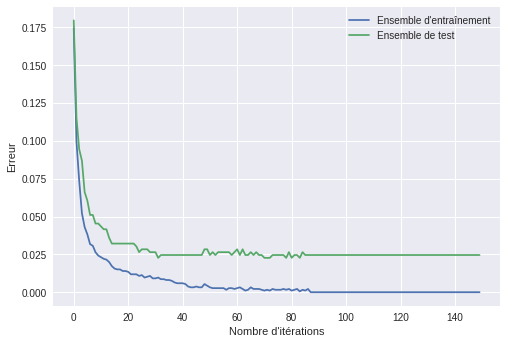

In [43]:
plt.figure()
model.errors(x06train, y06train, "Ensemble d'entraînement")
model.errors(x06test, y06test, "Ensemble de test")
plt.title("0 vs 6")
plt.legend()

In [45]:
xtrain,ytrain = get_usps([1, 2, 6, 8],xuspstrain,yuspstrain)
xtest,ytest = get_usps([1, 2, 6, 8],xuspstest,yuspstest)


ytrain = np.where(np.logical_or(ytrain==1, ytrain==2), 1, -1)
ytest = np.where(np.logical_or(ytest==1, ytest==2), 1, -1)

model2 = Perceptron(max_iter=150)
model2.fit(xtrain, ytrain)
print("score en train : ",model2.score(xtrain,ytrain))
print("score en test : ",model2.score(xtest,ytest))
print("weight matrix : ", model2.w)

0 [ 0.52096143]
100 [ 0.0084284]
score en train :  0.984364377974
score en test :  0.917293233083
weight matrix :  [[ 0.43721032  0.31912479 -0.05773351  0.31633464  0.11215217 -0.25655566
  -0.23111838  0.59486154  0.29960544  0.11992661 -0.07104127  0.38620539
   0.01448261  0.46108138  0.74602056  0.48828515  0.870107    0.52901486
  -0.38692089 -0.04047513  0.08362668  0.14279589  0.17204085  0.30001395
   0.53007119 -0.17614329 -0.14975914 -0.5746257  -0.33076488 -0.36897937
  -0.09992942  0.37035755  0.38830572 -0.38755713 -0.05114313 -0.14258762
   0.3478053  -0.27784807  0.02317222  0.10130922 -0.22337233  0.33855378
  -0.15616986 -0.20697719  0.66085535 -0.33778161 -0.06185919  0.83317409
   0.20827674  0.46215591 -0.03518983 -0.38359645  0.16623576  0.05864885
  -0.11613132  0.12389853  0.25784674  0.05631849 -0.45426136  0.4997793
   0.2918796   0.07852929 -0.00783557  0.33335791 -0.05221961 -0.14505823
  -0.19961784  0.28288478 -0.75158497  0.0945384  -0.21088409  0.4974480

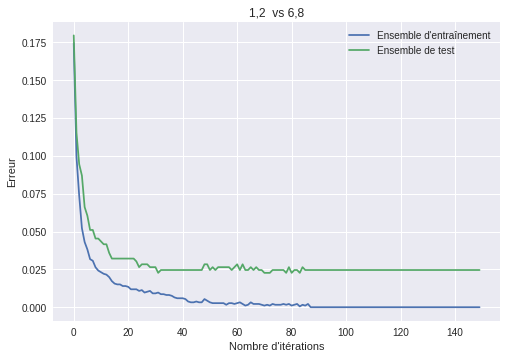

In [46]:
plt.figure()
model.errors(x06train, y06train, "Ensemble d'entraînement")
model.errors(x06test, y06test, "Ensemble de test")
plt.title("1,2  vs 6,8")
plt.legend()

**INTERPRETATION A FAIRE**

# 3 Expressivité et feature map

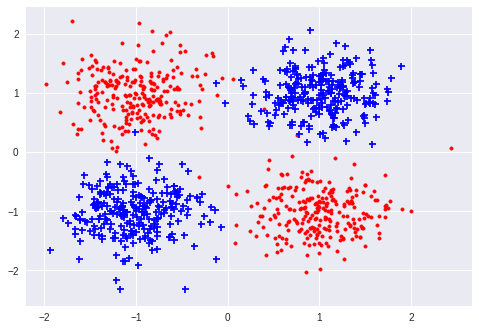

In [47]:
### Generation de donnees
xtrain,ytrain = gen_arti(data_type=1,epsilon=.2)
xtest,ytest = gen_arti(data_type=1,epsilon=.2)

plot_data(xtrain, ytrain)

plt.ion()


**DESCRPTION DATA**

0 [ 0.07932137]
100 [ 0.00112186]
200 [ 0.00092112]
300 [ 0.00082512]
400 [ 0.00132172]
score en train :  0.502
score en test :  0.498


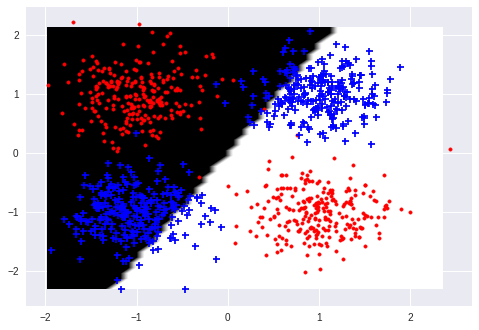

In [50]:
### Apprentissage
model= Perceptron(eps=1e-3, max_iter=500)
model.fit(xtrain,ytrain)
print("score en train : ",model.score(xtrain,ytrain))
print("score en test : ",model.score(xtest,ytest))
#### Tracer de frontiere
plt.figure()
plot_frontiere(xtrain,model.predict,50)
plot_data(xtrain,ytrain)

** INTERPRETATION **

In [53]:
def poly(x):
    """Only works in 2D"""
    n, d = np.shape(x)
    assert(d == 2)
    res = np.ones((n, 6))
    res[:, 1:3] = x
    res[:, 3] = x[:, 0]*x[:, 1]
    res[:, 4:6] = x*x
    return res

In [56]:
print(poly(xtrain)[:3,:])

[[ 1.          0.82701597 -0.94322887 -0.78006533  0.68395541  0.8896807 ]
 [ 1.         -1.39370694  0.53924674 -0.75155193  1.94241905  0.29078705]
 [ 1.          1.17745514 -1.25310822 -1.47547871  1.3864006   1.57028021]]


0 [ 0.08831154]
100 [ 0.0014287]
200 [ 0.00106339]
300 [ 0.00093515]
400 [ 0.00082695]
score en train :  0.989
score en test :  0.986


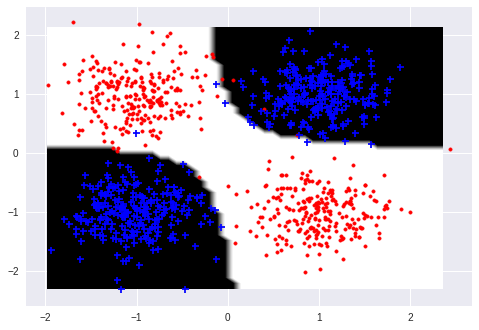

In [57]:
### Apprentissage
model= Perceptron(eps=1e-3, max_iter=500, projection=poly)
model.fit(xtrain,ytrain)
print("score en train : ",model.score(xtrain,ytrain))
print("score en test : ",model.score(xtest,ytest))
#### Tracer de frontiere
plt.figure()
plot_frontiere(xtrain,model.predict,50)
plot_data(xtrain,ytrain)

** Interprétation **

## Plongement gaussien

La ième dimension dans l'espace projeté correspond à la probabilité d'observer $X=x$ si X suit une loi gaussienne de moyenne $o^i$ et de variance $\sigma$ à une facteur de normalisation près.

Les $o^i$ correspondent à $N_b$ gaussiennes. Une valeur très importante de $k(x, o^i)$ signifiera qu'il y a une forte probabilité que $x$ soit issue de la gaussienne de paramètres $(o^i, \sigma)$
**A COMPLETER**

In [58]:
def k(x, xp, sigma):
    xp = xp.reshape(-1)
    norm = np.linalg.norm(x - xp, axis=1)
    return np.exp(-norm*norm/(2*sigma**2))


def gauss(B, x, sigma=1):
    """Conventions
    B matrice de taille Nb*d
    x matrice de taille n*d"""
    nb, db = np.shape(B)
    nx, dx = np.shape(x)
    res = np.zeros((nx, nb))
    for i in range(nb):
        o = B[i, :]
        res[:, i] = k(x, o, sigma)
    return res

def B(x, nb=10, mode=1, sigma=1):
    nx, dx = np.shape(x)
    if mode==1: # Centres pris aléatoirement
        min_x, max_x = np.amin(x, axis=0), np.amax(x, axis=0)
        matb = np.random.rand(nb, dx)
        matb = (max_x-min_x)*matb + min_x
    
    else: # Centres pris dans la base d'apprentissage
        indices = range(nx)
        indices = np.random.permutation(indices)
        matb = x[indices[:nb],:] # Question: faut-il modifier x
    return matb
